This project is a model showing urgent care centers distribution in St Louis neighborhood clusters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
import requests
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
!conda install -c conda-forge folium=0.5.0 --yes 
import folium
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    altair-4.0.0               |             py_0         606 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

In [4]:
#wikipedia page containing table for nighborhood demographics in St Louis
url='https://en.wikipedia.org/wiki/List_of_neighborhoods_of_St._Louis'
df=pd.read_html(url)[1]
df.head()

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor
0,Academy,3006,16.9,54.7,20.5,1.52,4.3,3.5,North
1,Baden,7268,6.3,91.8,0.5,0.10,0.0,1.3,North
2,Benton Park,3532,68.2,25.1,3.2,0.30,1.2,3.8,South
3,Benton Park West,4404,28.0,59.6,10.5,0.00,1.9,5.1,South
4,Bevo Mill,12654,74.2,13.8,7.5,0.40,4.6,3.9,South


In [5]:
df.shape

(79, 9)

In [6]:
# create a list of neighborhoods with 'St Louis' added. print first 5
locations=[]
addresses=[]
for neighborhood in df['Neighborhood']:
    address= neighborhood +' St Louis'
    addresses.append(address)
addresses[:5]

['Academy St Louis',
 'Baden St Louis',
 'Benton Park St Louis',
 'Benton Park West St Louis',
 'Bevo Mill St Louis']

In [10]:
#get neighborhood coordinates and put them in locations list
locations=[]
for address in addresses:
    geolocator = Nominatim(user_agent="stlouis_explorer")
    location = geolocator.geocode(address)
    locations.append(location)

In [11]:
#checks for None values and print index of None values
for i, location in enumerate(locations):
    if location == None:
        print(i)

35
64


In [12]:
#get missing neighborhood names from addresses list
print(addresses[35])
print(addresses[64])

JeffVanderLou St Louis
South Hampton St Louis


In [13]:
#removes None values from locations and puts other values to new list locations_c
locations_c= [i for i in locations if i]
print('Length of locations list is', len(locations))
print('Length of new locations_c list', len(locations_c))

Length of locations list is 79
Length of new locations_c list 77


In [14]:
#create lists for the latitudes, longitudes, and neighborhoods(berbs)
latitudes=[]
longitudes=[]
berbs=[]
for i, l in enumerate(locations_c):
    latitudes.append(l.latitude)
    longitudes.append(l.longitude)
    berb=l.address.split(',')
    berbs.append(berb[0])

In [15]:
#creat a data frame with neighborhoods and coordinates
df_berbs=pd.DataFrame()
df_berbs['Neighborhood']=berbs
df_berbs['Latitude']=latitudes
df_berbs['Longitude']=longitudes
df_berbs.head()

,Neighborhood,Latitude,Longitude
0,Academy,38.658421,-90.267226
1,Baden,38.717511,-90.231616
2,Benton Park,38.598678,-90.219755
3,Benton Park West,38.597977,-90.230015
4,Bevo Mill,38.581346,-90.267165


In [16]:
#get coordinate values of the 2 missing neighborhoods and insert them into data frame.
#JeffVanderLou St Louis lat = 38.6502 long = -90.2221
#South Hampton St Louis lat = 38.5871 long = -90.2831
df_berbs.loc[-1] = ['JeffVanderLou', 38.6502, -90.2221]  
df_berbs.index = df_berbs.index + 1  
df_berbs = df_berbs.sort_index() 
df_berbs.loc[-1] = ['South Hampton', 38.5871, -90.2831] 
df_berbs.index = df_berbs.index + 1  
df_berbs= df_berbs.sort_index()
df_berbs.reset_index(inplace = True) 
df_berbs.head()

,index,Neighborhood,Latitude,Longitude
0,0,South Hampton,38.587100,-90.283100
1,1,JeffVanderLou,38.650200,-90.222100
2,2,Academy,38.658421,-90.267226
3,3,Baden,38.717511,-90.231616
4,4,Benton Park,38.598678,-90.219755


In [17]:
#remove index column
df_berbs.drop("index", axis = 1, inplace=True)
#sort data frame by Neighborhood
df_berbs = df_berbs.sort_values(by='Neighborhood')
df_berbs.reset_index(drop=True, inplace = True)
df_berbs.head()

,Neighborhood,Latitude,Longitude
0,Academy,38.658421,-90.267226
1,Baden,38.717511,-90.231616
2,Benton Park,38.598678,-90.219755
3,Benton Park West,38.597977,-90.230015
4,Bevo Mill,38.581346,-90.267165


In [18]:
#check that demographics data frame and geographical data frame have same number of rows
print(df.shape)
print(df_berbs.shape)

(79, 9)
(79, 3)


In [19]:
#check for neighborhood name mismatches between the two data frames
lst1=df['Neighborhood'].tolist()
lst2=df_berbs['Neighborhood'].tolist()
#first print neighborhood names in geographical data frame that don't match names in the demographics data frame 
for i in lst2:
    if i not in lst1:
        print(i)

Covenant Blu Grand Center
Gate District
North Pointe
O'Fallon
Old North Saint Louis
Peabody-Darst-Webbe
Saint Louis Hills
Saint Louis Place
Skinker DeBaliviere
St. Louis
Wells Goodfellow
Wydown Skinker


In [20]:
#second print neighborhood names in demographics data frame that don't match names in the geographical data frame 
for i in lst1:
    if i in lst2:
        continue
    else:
        print(i)

The Gate District
Grand Center
The Hill
North Point
O’Fallon
Old North St. Louis
Peabody Darst Webbe
Skinker-DeBaliviere
St. Louis Hills
St. Louis Place
Wells/Goodfellow
Wydown/Skinker


In [21]:
#third replace the names in the geographical data frame with the names in the demographics data frame
df_berbs.replace("Covenant Blu Grand Center", 'Grand Center', inplace = True)
df_berbs.replace("Gate District", 'The Gate District', inplace = True)
df_berbs.replace('North Pointe','North Point', inplace = True)
df_berbs.replace('O\'Fallon','O’Fallon', inplace = True)
df_berbs.replace('Old North Saint Louis','Old North St. Louis',inplace=True)
df_berbs.replace('Peabody-Darst-Webbe','Peabody Darst Webbe',inplace=True)
df_berbs.replace('Saint Louis Hills','St. Louis Hills',inplace=True)
df_berbs.replace('Saint Louis Place','St. Louis Place',inplace=True)
df_berbs.replace('Skinker DeBaliviere','Skinker-DeBaliviere',inplace=True)
df_berbs.replace('St. Louis','The Hill',inplace=True)
df_berbs.replace('Wells Goodfellow','Wells/Goodfellow',inplace=True)
df_berbs.replace('Wydown Skinker','Wydown/Skinker',inplace=True)

In [22]:
#join the two data frames
df_stl=df.join(df_berbs.set_index('Neighborhood'), on='Neighborhood')
df_stl.head()

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor,Latitude,Longitude
0,Academy,3006,16.9,54.7,20.5,1.52,4.3,3.5,North,38.658421,-90.267226
1,Baden,7268,6.3,91.8,0.5,0.10,0.0,1.3,North,38.717511,-90.231616
2,Benton Park,3532,68.2,25.1,3.2,0.30,1.2,3.8,South,38.598678,-90.219755
3,Benton Park West,4404,28.0,59.6,10.5,0.00,1.9,5.1,South,38.597977,-90.230015
4,Bevo Mill,12654,74.2,13.8,7.5,0.40,4.6,3.9,South,38.581346,-90.267165


Save the df_stl Data Frame!

In [2]:
# The code was removed by Watson Studio for sharing.

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor,Latitude,Longitude
0,Academy,3006,16.9,54.7,20.5,1.52,4.3,3.5,North,38.658421,-90.267226
1,Baden,7268,6.3,91.8,0.5,0.10,0.0,1.3,North,38.717511,-90.231616
2,Benton Park,3532,68.2,25.1,3.2,0.30,1.2,3.8,South,38.598678,-90.219755
3,Benton Park West,4404,28.0,59.6,10.5,0.00,1.9,5.1,South,38.597977,-90.230015
4,Bevo Mill,12654,74.2,13.8,7.5,0.40,4.6,3.9,South,38.581346,-90.267165


In [3]:
#get geographical coordinates of St Louis
address = 'St Louis'
geolocator = Nominatim(user_agent="stlouis_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of St. Louis are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of St. Louis are 38.6268039, -90.1994097.


In [4]:
# create map of St Louis using latitude and longitude values
map_stl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map to visiualize the different St Louis neighborhoods
for lat, lng, neighborhood in zip(df_stl['Latitude'], df_stl['Longitude'], df_stl['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stl)  
    
map_stl

In [5]:
#Examine St Louis poplulation distribution in Centeral, North and South
df_corridor = df_stl[['Population','Corridor']]
df_corridor=df_corridor.groupby('Corridor', axis=0).sum()
df_corridor

,Population
Corridor,
Central,61950
North,98937
South,158595


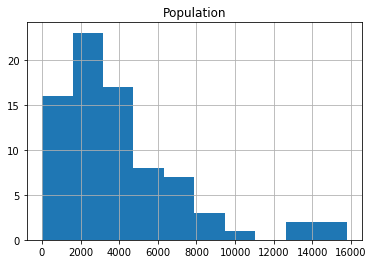

In [6]:
#Histogram of St Louis population showing distribution among neighborhoods. 
viz = df_stl[['Neighborhood','Population']]
viz.hist()
plt.show()

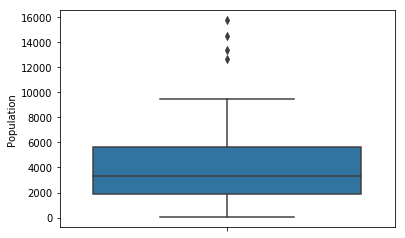

In [7]:
#Boxplot of St Louis population.
sns.boxplot(y="Population", data=df_stl)

In [8]:
#binning neighborhoods into 3 groups based on population
bins = np.linspace(min(df_stl["Population"]), max(df_stl["Population"]), 4) 
group_names = ['Low', 'Medium', 'High']
#add bins to data frame
df_stl['Population-binned'] = pd.cut(df_stl['Population'], bins, labels=group_names, include_lowest=True )
df_stl.head()

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor,Latitude,Longitude,Population-binned
0,Academy,3006,16.9,54.7,20.5,1.52,4.3,3.5,North,38.658421,-90.267226,Low
1,Baden,7268,6.3,91.8,0.5,0.10,0.0,1.3,North,38.717511,-90.231616,Medium
2,Benton Park,3532,68.2,25.1,3.2,0.30,1.2,3.8,South,38.598678,-90.219755,Low
3,Benton Park West,4404,28.0,59.6,10.5,0.00,1.9,5.1,South,38.597977,-90.230015,Low
4,Bevo Mill,12654,74.2,13.8,7.5,0.40,4.6,3.9,South,38.581346,-90.267165,High


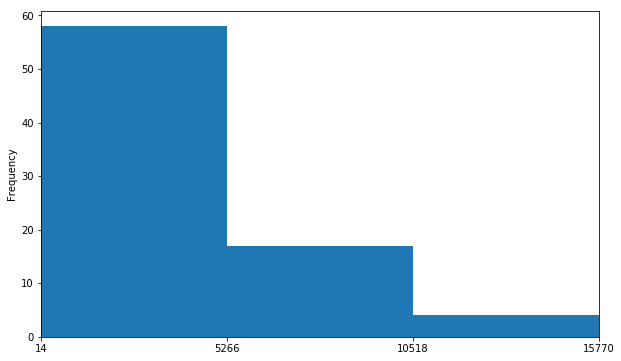

In [9]:
#plot the 3 bins
count, bin_edges = np.histogram(df_stl['Population'],3)
df_stl['Population'].plot(kind='hist',figsize=(10, 6), bins=3,
                           xticks=bin_edges,stacked=True,xlim=(min(df_stl["Population"]), max(df_stl["Population"])) )

Insert Foursquare credentials

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
# Foursquare query urgent cares in st louis
search_query = 'Urgent Care'
latitude=latitude
longitude=longitude


In [12]:
#Foursquare url for urgent care seach in St Louis
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}'.format(CLIENT_ID, 
        CLIENT_SECRET, latitude, longitude, VERSION, search_query)

In [20]:
#Foursquare results. print information of first result
results = requests.get(url).json()
results['response']['venues'][0]

{'id': '4af9a7d9f964a520f91222e3',
 'name': 'Downtown Urgent Care',
 'location': {'address': '916 Olive St',
  'crossStreet': 'btw 9th & 10th',
  'lat': 38.62880902864708,
  'lng': -90.19455811677757,
  'labeledLatLngs': [{'label': 'display',
    'lat': 38.62880902864708,
    'lng': -90.19455811677757}],
  'distance': 477,
  'postalCode': '63101',
  'cc': 'US',
  'city': 'St Louis',
  'state': 'MO',
  'country': 'United States',
  'formattedAddress': ['916 Olive St (btw 9th & 10th)',
   'St Louis, MO 63101',
   'United States']},
 'categories': [{'id': '56aa371be4b08b9a8d573526',
   'name': 'Urgent Care Center',
   'pluralName': 'Urgent Care Centers',
   'shortName': 'Urgent Care Center',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1578582597',
 'hasPerk': False}

In [21]:
# assign relevant part of JSON to stl_ucs
stl_ucs = results['response']['venues']

# tranform into a dataframe
df_stl_uc = json_normalize(stl_ucs)
df_stl_uc.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '56aa371be4b08b9a8d573526', 'name': 'U...",False,4af9a7d9f964a520f91222e3,916 Olive St,US,St Louis,United States,btw 9th & 10th,477,"[916 Olive St (btw 9th & 10th), St Louis, MO 6...","[{'label': 'display', 'lat': 38.62880902864708...",38.628809,-90.194558,63101,MO,Downtown Urgent Care,v-1578582597,NaN
1,"[{'id': '56aa371be4b08b9a8d573526', 'name': 'U...",False,510863e7e4b0b8521928422f,916 Olive St,US,St Louis,United States,NaN,545,"[916 Olive St, St Louis, MO 63101, United States]","[{'label': 'display', 'lat': 38.62911224365234...",38.629112,-90.193871,63101,MO,St. Louis Urgent Care,v-1578582597,NaN
2,"[{'id': '4bf58dd8d48988d104941735', 'name': 'M...",False,4f2c474be4b0390a2205cba0,3100 Market St,US,St Louis,United States,Lafayette,2278,"[3100 Market St (Lafayette), St Louis, MO 6310...","[{'label': 'display', 'lat': 38.63078367247781...",38.630784,-90.225105,63103,MO,Concentra Urgent Care,v-1578582597,NaN
3,"[{'id': '56aa371be4b08b9a8d573526', 'name': 'U...",False,4e8241eaf790103b982cd273,1617 S 3rd St,US,St Louis,United States,NaN,1903,"[1617 S 3rd St, St Louis, MO 63104, United Sta...","[{'label': 'display', 'lat': 38.61168221326539...",38.611682,-90.209618,63104,MO,Concerta Urgent Care,v-1578582597,NaN
4,"[{'id': '4bf58dd8d48988d104941735', 'name': 'M...",False,4d2caa98467d6ea8de87ea95,8340 N Broadway,US,St Louis,United States,NaN,9921,"[8340 N Broadway, St Louis, MO 63147, United S...","[{'label': 'display', 'lat': 38.71288699572327...",38.712887,-90.228990,63147,MO,Concentra Urgent Care,v-1578582597,NaN


In [22]:
df_stl_uc.shape

(30, 18)

In [23]:
#drop unneeded columns
df_stl_uc.drop(['categories','hasPerk','id','location.cc','location.country','location.crossStreet',
                          'location.labeledLatLngs','referralId','venuePage.id'], axis = 1, inplace=True)
df_stl_uc.head()

,location.address,location.city,location.distance,location.formattedAddress,location.lat,location.lng,location.postalCode,location.state,name
0,916 Olive St,St Louis,477,"[916 Olive St (btw 9th & 10th), St Louis, MO 6...",38.628809,-90.194558,63101,MO,Downtown Urgent Care
1,916 Olive St,St Louis,545,"[916 Olive St, St Louis, MO 63101, United States]",38.629112,-90.193871,63101,MO,St. Louis Urgent Care
2,3100 Market St,St Louis,2278,"[3100 Market St (Lafayette), St Louis, MO 6310...",38.630784,-90.225105,63103,MO,Concentra Urgent Care
3,1617 S 3rd St,St Louis,1903,"[1617 S 3rd St, St Louis, MO 63104, United Sta...",38.611682,-90.209618,63104,MO,Concerta Urgent Care
4,8340 N Broadway,St Louis,9921,"[8340 N Broadway, St Louis, MO 63147, United S...",38.712887,-90.228990,63147,MO,Concentra Urgent Care


In [24]:
df_stl_uc.shape

(30, 9)

In [25]:
#rename columns to remove 'location.'
df_stl_uc.columns = [column.split('.')[-1] for column in df_stl_uc.columns]
df_stl_uc.head()

,address,city,distance,formattedAddress,lat,lng,postalCode,state,name
0,916 Olive St,St Louis,477,"[916 Olive St (btw 9th & 10th), St Louis, MO 6...",38.628809,-90.194558,63101,MO,Downtown Urgent Care
1,916 Olive St,St Louis,545,"[916 Olive St, St Louis, MO 63101, United States]",38.629112,-90.193871,63101,MO,St. Louis Urgent Care
2,3100 Market St,St Louis,2278,"[3100 Market St (Lafayette), St Louis, MO 6310...",38.630784,-90.225105,63103,MO,Concentra Urgent Care
3,1617 S 3rd St,St Louis,1903,"[1617 S 3rd St, St Louis, MO 63104, United Sta...",38.611682,-90.209618,63104,MO,Concerta Urgent Care
4,8340 N Broadway,St Louis,9921,"[8340 N Broadway, St Louis, MO 63147, United S...",38.712887,-90.228990,63147,MO,Concentra Urgent Care


In [26]:
#only keep rows that are in St Louis
df_stl_uc=df_stl_uc[df_stl_uc.city=='St Louis']
df_stl_uc.head()

,address,city,distance,formattedAddress,lat,lng,postalCode,state,name
0,916 Olive St,St Louis,477,"[916 Olive St (btw 9th & 10th), St Louis, MO 6...",38.628809,-90.194558,63101,MO,Downtown Urgent Care
1,916 Olive St,St Louis,545,"[916 Olive St, St Louis, MO 63101, United States]",38.629112,-90.193871,63101,MO,St. Louis Urgent Care
2,3100 Market St,St Louis,2278,"[3100 Market St (Lafayette), St Louis, MO 6310...",38.630784,-90.225105,63103,MO,Concentra Urgent Care
3,1617 S 3rd St,St Louis,1903,"[1617 S 3rd St, St Louis, MO 63104, United Sta...",38.611682,-90.209618,63104,MO,Concerta Urgent Care
4,8340 N Broadway,St Louis,9921,"[8340 N Broadway, St Louis, MO 63147, United S...",38.712887,-90.228990,63147,MO,Concentra Urgent Care


In [27]:
df_stl_uc.reset_index(drop=True, inplace=True)
df_stl_uc.shape

(12, 9)

In [28]:
#check the adresses of the different urgent cares
df_stl_uc['address']

0             916 Olive St
1             916 Olive St
2           3100 Market St
3            1617 S 3rd St
4          8340 N Broadway
5           Lemay Ferry Rd
6        3114 S Grand Blvd
7      6542 Manchester Ave
8     4100 Forest Park Ave
9         2060 Hampton Ave
10                     NaN
11        6900 Chippewa St
Name: address, dtype: object

In [29]:
#the second row has the same address as the first row. remove the duplicate
df_stl_uc.drop(index=1,inplace=True)
df_stl_uc.reset_index(drop=True, inplace=True)
df_stl_uc.shape

(11, 9)

In [31]:
# create map of urgent cares in St Louis
map_centers = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to the map

for lat, lon, poi in zip(df_stl_uc['lat'], df_stl_uc['lng'], df_stl_uc['name']):
    label = folium.Popup(str(poi))
    folium.Marker(
        [lat, lon],
        popup=label).add_to(map_centers)
map_centers

In [32]:
#Lemay Urgent Care is outside St Louis. Remove it from df_stl_uc
df_stl_uc=df_stl_uc[df_stl_uc.name != 'Lemay Urgent Care']
df_stl_uc.shape

(10, 9)

In [34]:
#print the data frame. index 9 has no address, but has the coordinates that we need.
df_stl_uc.reset_index(drop=True, inplace=True)
df_stl_uc.head(10)

,address,city,distance,formattedAddress,lat,lng,postalCode,state,name
0,916 Olive St,St Louis,477,"[916 Olive St (btw 9th & 10th), St Louis, MO 6...",38.628809,-90.194558,63101,MO,Downtown Urgent Care
1,3100 Market St,St Louis,2278,"[3100 Market St (Lafayette), St Louis, MO 6310...",38.630784,-90.225105,63103,MO,Concentra Urgent Care
2,1617 S 3rd St,St Louis,1903,"[1617 S 3rd St, St Louis, MO 63104, United Sta...",38.611682,-90.209618,63104,MO,Concerta Urgent Care
3,8340 N Broadway,St Louis,9921,"[8340 N Broadway, St Louis, MO 63147, United S...",38.712887,-90.228990,63147,MO,Concentra Urgent Care
4,3114 S Grand Blvd,St Louis,4617,"[3114 S Grand Blvd, St Louis, MO 63118, United...",38.602133,-90.242083,63118,MO,Total Access Urgent Care
5,6542 Manchester Ave,St Louis,8641,"[6542 Manchester Ave, St Louis, MO 63139, Unit...",38.619237,-90.298297,63139,MO,Concentra Urgent Care
6,4100 Forest Park Ave,St Louis,4282,"[4100 Forest Park Ave, St Louis, MO 63108, Uni...",38.635858,-90.247270,63108,MO,Urgent Care For Kids
7,2060 Hampton Ave,St Louis,7700,"[2060 Hampton Ave, St Louis, MO 63139, United ...",38.617848,-90.287209,63139,MO,Total Access Urgent Care
8,NaN,St Louis,8671,"[St Louis, MO, United States]",38.593022,-90.289232,NaN,MO,Fast Track Urgent Care
9,6900 Chippewa St,St Louis,10479,"[6900 Chippewa St, St Louis, MO 63109, United ...",38.588476,-90.309441,63109,MO,Total Access Urgent Care


In [35]:
#create data frame for K means clustering
#cluster based on coordinates of St Louis neighborhoods
df_stl_k=df_stl[['Latitude','Longitude']]
df_stl_k.head()

,Latitude,Longitude
0,38.658421,-90.267226
1,38.717511,-90.231616
2,38.598678,-90.219755
3,38.597977,-90.230015
4,38.581346,-90.267165


In [36]:
#fit transform data for clustering
from sklearn.preprocessing import StandardScaler
Clus_dataSet = StandardScaler().fit_transform(df_stl_k)

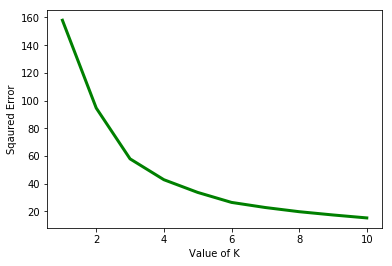

In [37]:
#determine best value for cluster numbers. It is determined by the point of the elbow
se =[] 
for i in range(1, 11): 
    KM = KMeans(init = "k-means++", n_clusters = i, n_init=12) 
    KM.fit(Clus_dataSet) 
      
    # calculates squared error for the clustered points 
    se.append(KM.inertia_)      

plt.plot(range(1, 11), se, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error") 
plt.show()

In [38]:
#choose 6 as number of clusters
k_means = KMeans(init = "k-means++", n_clusters = 6, n_init=12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
print(labels)

[0 4 1 1 5 1 5 5 2 0 3 3 3 2 2 1 0 2 2 5 3 2 1 0 1 3 1 2 1 0 0 2 3 5 2 2 3
 0 0 2 2 2 0 3 1 4 0 1 2 5 2 3 4 4 4 2 5 2 4 5 4 1 3 2 3 3 3 2 1 1 1 0 0 0
 4 4 0 0 3]


In [39]:
#add the cluster label to original data frame
df_stl["Clus_km"] = labels
df_stl.head()

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor,Latitude,Longitude,Population-binned,Clus_km
0,Academy,3006,16.9,54.7,20.5,1.52,4.3,3.5,North,38.658421,-90.267226,Low,0
1,Baden,7268,6.3,91.8,0.5,0.10,0.0,1.3,North,38.717511,-90.231616,Medium,4
2,Benton Park,3532,68.2,25.1,3.2,0.30,1.2,3.8,South,38.598678,-90.219755,Low,1
3,Benton Park West,4404,28.0,59.6,10.5,0.00,1.9,5.1,South,38.597977,-90.230015,Low,1
4,Bevo Mill,12654,74.2,13.8,7.5,0.40,4.6,3.9,South,38.581346,-90.267165,High,5


In [40]:
#visualize on St Louis map neighborhoods based on their cluster 
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
clusterNum=6
# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_stl['Latitude'], df_stl['Longitude'], df_stl['Neighborhood'], df_stl['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [41]:
#visualize on St Louis map neighborhoods based on their cluster with urgent cares 
map_clusters_centers = folium.Map(location=[latitude, longitude], zoom_start=11)
clusterNum=6
# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_stl['Latitude'], df_stl['Longitude'], df_stl['Neighborhood'], df_stl['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_centers)
for lat, lon, poi in zip(df_stl_uc['lat'], df_stl_uc['lng'], df_stl_uc['name']):
    label = folium.Popup(str(poi))
    folium.Marker(
        [lat, lon],
        popup=label).add_to(map_clusters_centers)
       
map_clusters_centers



In [42]:
# the population of each cluster
df_stl[['Population','Clus_km']].groupby('Clus_km').sum()

,Population
Clus_km,
0,58617
1,55854
2,50466
3,54009
4,36320
5,64216
